## Load Dataset

In [1]:
# For Fisher Score
!pip install skfeature-chappers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from skfeature.function.similarity_based import fisher_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from imblearn.under_sampling import NearMiss, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
%matplotlib inline

# Load data
df = pd.read_csv('CustomerChurn.csv')

print(f'Shape of dataset: {df.shape}') # (rows, columns)

# Move column
column_name = df.pop('Attrition_Flag')

df.insert(15, 'Attrition_Flag', column_name)

df.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 66 kB 2.5 MB/s 
Shape of dataset: (6237, 16)


,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive,Contacts_Count,Credit_Limit,Total_Revolving_Bal,Total_Trans_Amt,Total_Trans_Ct,Attrition_Flag
0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,1144,42,Existing Customer
1,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,1291,33,Existing Customer
2,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,1887,20,Existing Customer
3,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,816,28,Existing Customer
4,44,M,2,Graduate,Married,$40K - $60K,Blue,36,3,1,2,4010.0,1247,1088,24,Existing Customer


## Data Visualization

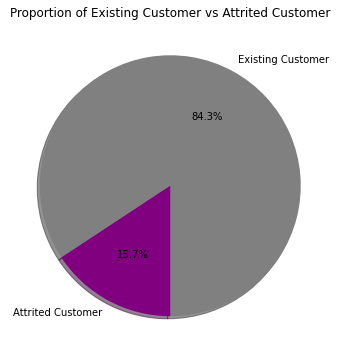


Existing Customer    5256
Attrited Customer     981
Name: Attrition_Flag, dtype: int64



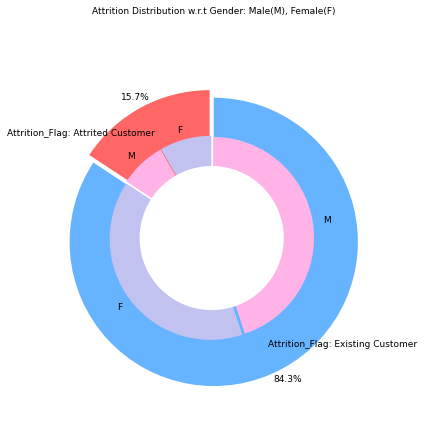

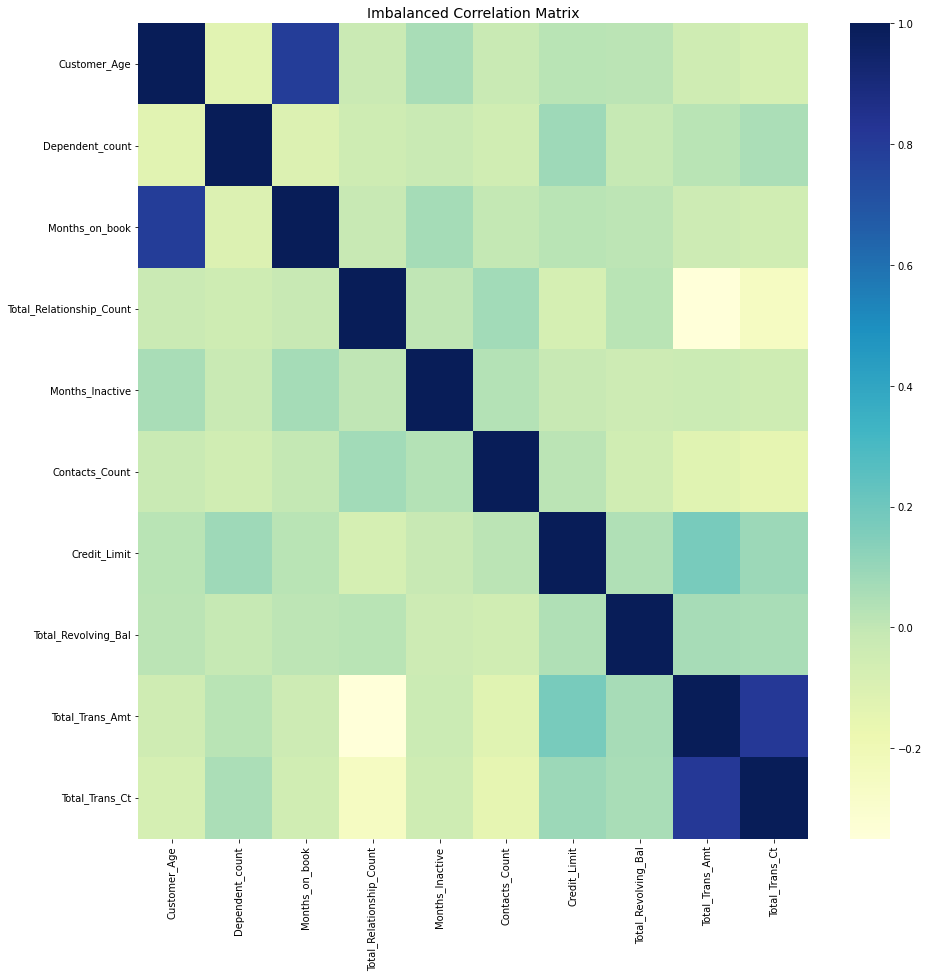

In [2]:
# Setup for Attrition Flag
sizes = df['Attrition_Flag'].value_counts(sort = True)
colors = ["grey","purple"] 
labels = ['Existing Customer', 'Attrited Customer']
rcParams['figure.figsize'] = 6,6

# Plot 
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=270,)
plt.title('Proportion of Existing Customer vs Attrited Customer')
plt.show()

# Show the number of occurrence btw EC vs AC
print(f"\n{df['Attrition_Flag'].value_counts()}\n")

# Use the below to retrieve the distribution for Gender - EC vs AC 
#df["Attrition_Flag"][df["Attrition_Flag"]=="Existing Customer"].groupby(by=df["Gender"]).count()
#df["Attrition_Flag"][df["Attrition_Flag"]=="Attrited Customer"].groupby(by=df["Gender"]).count()


# Setup for Gender vs Attrition Flag
plt.figure(figsize=(6, 6))
labels =["Attrition_Flag: Attrited Customer","Attrition_Flag: Existing Customer"]
values = [981,5256]
labels_gender = ["F","M","F","M"]
sizes_gender = [517,464 , 2455,2801]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6']
explode = (0.3,0.3) 
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":9}

#Use pie
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.08, labeldistance=0.8,colors=colors, startangle=90,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender,startangle=90, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )

#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Attrition Distribution w.r.t Gender: Male(M), Female(F)', fontsize=9, y=1.1)

# Show plot 
plt.axis('equal')
plt.tight_layout()
plt.show()

print('\n') # next line

#Setup for Income Category
fig = px.histogram(df, x="Attrition_Flag", color="Income_Category", title="<b>Income Category distribution w.r.t. Attrition Flag</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

print('\n') # next line

# Setup for Martial Status
color_map = {"Attrited Customer": '#FFA15A', "Existing Customer": '#00CC96'}
fig = px.histogram(df, x="Attrition_Flag", color="Marital_Status", barmode="group", title="<b>Attrition distribution w.r.t. Marital Status</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

print('\n')
# Independent variables weight on target variable. Correlation matrix before resampling
fig, ax = plt.subplots(figsize=(15,15)) 
#plt.figure(figsize=(13,13))
sns.heatmap(df.corr(), cmap='YlGnBu', annot_kws={'size':20}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)
plt.show()


## Data Preprocessing and Feature Selection/Engineering


Show columns with null values: 
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive             0
Contacts_Count              0
Credit_Limit                0
Total_Revolving_Bal         0
Total_Trans_Amt             0
Total_Trans_Ct              0
Attrition_Flag              0
dtype: int64

Feature selection using fisher's score:


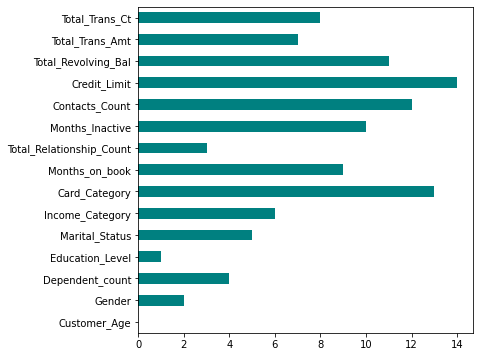


Feature selection using infomation gain:


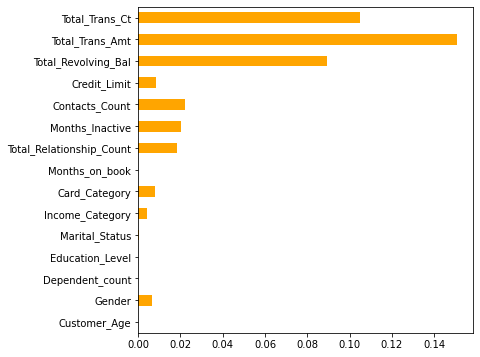

In [3]:
# Check for missing values
print(f'\nShow columns with null values: \n{df.isnull().sum()}') # apparently, there are no null values in the dataset.
# OR
# msno.matrix(df);

# Convert categorical values to numerical values. Alternatively, you can use map or replace instead.
def object_to_int(dataframe_series):
  if dataframe_series.dtype == 'object':
    dataframe_series = LabelEncoder().fit_transform(dataframe_series)
  return dataframe_series

df = df.apply(lambda x: object_to_int(x))

#data = df.values
data_X = df.drop(['Attrition_Flag'], axis=1).values #data[:,0:15]  
data_y = df['Attrition_Flag'].values 

# Feature Selection and Engineering
print("\nFeature selection using fisher's score:")
# Calculate fisher's score
ranks = fisher_score.fisher_score(data_X, data_y)

# Plotting ranks
feature_importance = pd.Series(ranks, df.columns[0: len(df.columns) - 1])
feature_importance.plot(kind='barh', color='teal')
plt.show()

print('\nFeature selection using infomation gain:')
# Calculate information gain
info_gain = mutual_info_classif(data_X, data_y)

# Plotting info gain
info_importance = pd.Series(info_gain, df.columns[0: len(df.columns) - 1])
info_importance.plot(kind='barh', color='orange')
plt.show()

# Drop irrelevant features
#df.drop(columns=['Education_Level', 'Income_Category', 'Card_Category'], inplace=True)

# Convert Object to numeric, float64 to int64
#df['Attrition_Flag'] = df['Attrition_Flag'].astype('int64')

# Checking the data types of all the columns
#print(f'\n{df.dtypes}')

#df.head()

## Split Dataset and Feature Scaling

In [4]:
# Split dataset before resampling
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=.25, random_state=42, stratify=data_y)

# Perform feature scaling using standardization
scaler = StandardScaler().fit(X_train)
X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)

## Resampling

In [5]:
# Under-sampling {I do not recommended this}
#nm = NearMiss()
#resampled_X, resampled_y = nm.fit_resample(data_X, data_y)

# Over-sampling
smote = SMOTE() 
resampled_X, resampled_y = smote.fit_resample(X_train_normalized, y_train)
# OR
#imbl_over = RandomOverSampler(random_state=42)
#resampled_X, resampled_y = imbl_over.fit_resample(data_X, data_y)

print('Original dataset shape:', Counter(y_train))
print('Resample dataset shape:', Counter(resampled_y))

# Independent variables weight on target variable. Correlation matrix before resampling
#fig, ax = plt.subplots(figsize=(20,10)) 

#combined_df = pd.DataFrame(resampled_X, columns=['Customer_Age',	'Gender', 'Dependent_count',	'Education_Level',	'Marital_Status',	'Income_Category',	'Card_Category',	'Months_on_book',	'Total_Relationship_Count',	'Months_Inactive',	'Contacts_Count',	'Credit_Limit',	'Total_Revolving_Bal',	'Total_Trans_Amt',	'Total_Trans_Ct'])
#combined_df['Attrition_Flag'] = resampled_y

#sns.heatmap(combined_df.corr(), cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
#ax.set_title("Balanced Correlation Matrix", fontsize=14)
#plt.show()

Original dataset shape: Counter({1: 3941, 0: 736})
Resample dataset shape: Counter({1: 3941, 0: 3941})


## Build Model: Random Forest


Performance metric for RFC:
ROCAUC score: 90.28%
Accuracy score: 93.97%
F1 score: 96.40%

Classification report: 
              precision    recall  f1-score   support

           0       0.78      0.85      0.82       245
           1       0.97      0.96      0.96      1315

    accuracy                           0.94      1560
   macro avg       0.88      0.90      0.89      1560
weighted avg       0.94      0.94      0.94      1560



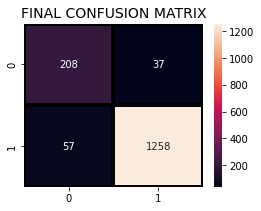


Feature importance chart:


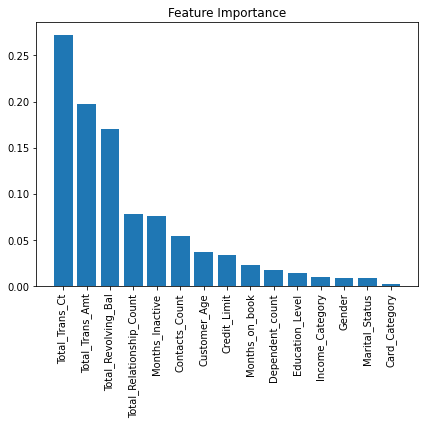

In [ ]:
# Random Forest Algorithm
# Number of trees in random forest
n_estimators = np.linspace(1300, 1500, 5, dtype=int) #np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)

# Maximum number of levels/depth in tree
max_depth = [1, 5, 10, 20]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]

# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4]

# Criterion
#criterion = ['gini', 'entropy']

# Maximum number of features in each tree
max_features = [3, 4, 5, 6, 7]

random_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features
              }

rfc = RandomForestClassifier(n_estimators=1350, max_depth=20, min_samples_split=5, min_samples_leaf=3, max_features=4, bootstrap=True, random_state=42)
rfc_model = RandomizedSearchCV(estimator = rfc,
                               param_distributions = random_grid, # for Randomized
                               #param_grid = random_grid,                               
                               n_iter = 15, 
                               cv = 5,
                               verbose=2,
                               random_state=42, 
                               n_jobs = 4)

# Fit the predictor and target
rfc.fit(resampled_X, resampled_y)

#best_estimator = rfc_model.best_estimator_
#print(f'\nBest Params: {rfc_model.best_params_}')

# Predict
rfc_predict = rfc.predict(X_test_normalized)

print('\nPerformance metric for RFC:')
# Performance metric: RFC
print('ROCAUC score: {:.2f}%'.format(roc_auc_score(y_test, rfc_predict)*100))
print('Accuracy score: {:.2f}%'.format(accuracy_score(y_test, rfc_predict)*100))
print('F1 score: {:.2f}%'.format(f1_score(y_test, rfc_predict)*100)) # Recommended
print(f'\nClassification report: \n{classification_report(y_test, rfc_predict)}')    

plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, rfc_predict),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("FINAL CONFUSION MATRIX",fontsize=14)
plt.show()

print('\nFeature importance chart:')
importance = rfc.feature_importances_

# Sort the feature importance in descending order
sorted_indices = np.argsort(importance)[::-1]
 
feature_labels = df.columns[1:]
    
plt.title('Feature Importance')
plt.bar(range(X_train_normalized.shape[1]), importance[sorted_indices], align='center')
plt.xticks(range(X_train_normalized.shape[1]), df.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

## Build Model: Support Vector Machine

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.562 total time=   7.0s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.587 total time=   8.1s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.588 total time=   7.3s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.576 total time=   4.0s
[CV 5/5] END ....................C=0.1, gamma=1;, score=0.600 total time=   4.0s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.869 total time=   1.9s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.895 total time=   2.0s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.893 total time=   1.9s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.911 total time=   2.7s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.907 total time=   2.0s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.822 total time=   2.1s
[CV 2/5] END .................C=0.1, gamma=0.01

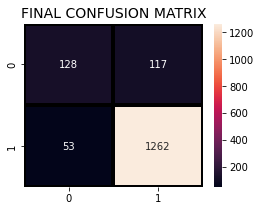

In [8]:
# Support Vector Machine
# We can add class_weight='balanced',probability=True to add penalize mistake
svc = SVC(random_state=15)

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.3, 0.03, 0.003, 0.0003]} 
  
svc_model = GridSearchCV(svc, param_grid, refit = True, verbose = 3)

svc_model.fit(resampled_X, resampled_y)

svc_predict = svc_model.predict(X_test_normalized)

print('\nPerformance metric for SVM:')
# Performance metric: SVM
print('ROCAUC score: {:.2f}%'.format(roc_auc_score(y_test, svc_predict)*100))
print('Accuracy score: {:.2f}%'.format(accuracy_score(y_test, svc_predict)*100))
print('F1 score: {:.2f}%'.format(f1_score(y_test, svc_predict)*100))
print(f'\nClassification report: \n{classification_report(y_test, svc_predict)}') 

plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, svc_predict),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("FINAL CONFUSION MATRIX",fontsize=14)
plt.show()